In [1]:
import os, platform, pprint, sys
import fastai
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sklearn
import yellowbrick as yb

from fastai.tabular.data import TabularDataLoaders, TabularPandas
from fastai.tabular.all import FillMissing, Categorify, Normalize, tabular_learner, accuracy, ClassificationInterpretation, ShowGraphCallback, RandomSplitter, range_of

from sklearn.base import BaseEstimator
from sklearn.metrics import accuracy_score, classification_report
from sklearn.neighbors import KNeighborsClassifier

from yellowbrick.model_selection import CVScores, LearningCurve, ValidationCurve



seed: int = 14


# set up pretty printer for easier data evaluation
pretty = pprint.PrettyPrinter(indent=4, width=30).pprint


# declare file paths for the data we will be working on
data_path_1: str = '../data/prepared/baseline/'
data_path_2: str = '../data/prepared/timebased/'
modelPath  : str = './models'


# list the names of the datasets we will be using
attacks : list = [ 'DNS', 'LDAP', 'MSSQL', 'NetBIOS', 'NTP', 'Portmap', 'SNMP', 'SSDP', 'Syn', 'TFTP', 'UDP', 'UDPLag' ]
datasets: list = [
    "DNS_vs_benign.csv" , "LDAP_vs_benign.csv"    , "MSSQL_vs_benign.csv" , "NetBIOS_vs_benign.csv" ,
    "NTP_vs_benign.csv" , "Portmap_vs_benign.csv" , "SNMP_vs_benign.csv"  , "SSDP_vs_benign.csv"    ,
    "Syn_vs_benign.csv" , "TFTP_vs_benign.csv"    , "UDP_vs_benign.csv"   , "UDPLag_vs_benign.csv"  ,
]


# set up enumeration of experiment types
Baseline : int = 0
Timebased: int = 1


# print library and python versions for reproducibility
print(
    f'''
    python:\t{platform.python_version()}

    \tfastai:\t\t{fastai.__version__}
    \tmatplotlib:\t{mpl.__version__}
    \tnumpy:\t\t{np.__version__}
    \tpandas:\t\t{pd.__version__}
    \tsklearn:\t{sklearn.__version__}
    \tyellowbrick:\t{yb.__version__}
    '''
)


    python:	3.7.10

    	fastai:		2.4.1
    	matplotlib:	3.3.4
    	numpy:		1.20.3
    	pandas:		1.2.5
    	sklearn:	0.24.2
    	yellowbrick:	1.3.post1
    


In [2]:
def get_file_path(directory: str):
    '''
        Closure that will return a function that returns the filepath to the directory given to the closure
    '''

    def func(file: str) -> str:
        return os.path.join(directory, file)

    return func


# use the get_file_path closure to create a function that will return the path to a file
baseline_path  = get_file_path(data_path_1)
timebased_path = get_file_path(data_path_2)


# create a list of the paths to all of the dataset files
baseline_files : list = list(map(baseline_path , datasets))
timebased_files: list = list(map(timebased_path, datasets))

In [ ]:
def load_data(filePath: str) -> pd.DataFrame:
    '''
        Loads the Dataset from the given filepath and caches it for quick access in the future
        Function will only work when filepath is a .csv file
    '''

    # slice off the ./CSV/ from the filePath
    if filePath[0] == '.' and filePath[1] == '.':
        filePathClean: str = filePath[17::]
        pickleDump: str = f'../data/cache/{filePathClean}.pickle'
    else:
        pickleDump: str = f'../data/cache/{filePath}.pickle'
    
    print(f'Loading Dataset: {filePath}')
    print(f'\tTo Dataset Cache: {pickleDump}\n')
    
    # check if data already exists within cache
    if os.path.exists(pickleDump):
        df = pd.read_pickle(pickleDump)
        
    # if not, load data and cache it
    else:
        df = pd.read_csv(filePath, low_memory=True)
        df.to_pickle(pickleDump)

    
    return df


def run_experiment(df, name, binary=True):
    '''
        Run binary classification using K-Nearest Neighbors, saving the model as {name}.model
    '''
    dep_var: str = 'Label'
    unused_categories: list = []
    selected_features = list(set(df) - set(unused_categories) - set([dep_var]))

    procs = [FillMissing, Categorify, Normalize]
    splits = RandomSplitter(valid_pct=0.2, seed=seed)(range_of(df))
    

    to = TabularPandas(df, y_names=dep_var, cat_names=[], cont_names=selected_features, procs=procs, splits=splits)

    dls = to.dataloaders(bs=64)
    mds = tabular_learner(dls)

    X_train = to.train.xs.reset_index(drop=True)
    X_test = to.valid.xs.reset_index(drop=True)
    y_train = to.train.ys.values.ravel()
    y_test = to.valid.ys.values.ravel()

    model = KNeighborsClassifier()
    model.fit(X_train, y_train)
    prediction = model.predict(X_test)
    report = classification_report(y_test, prediction)
    print(report)

    if binary:
        model.target_type_ = 'binary'
    else:  
        model.target_type_ = 'multiclass'


    classes : list = list(mds.dls.vocab)
    viz_data: tuple = (model, classes, X_test, y_test, name, X_train, y_train)

    visualizer = LearningCurve(model, scoring='f1_weighted')
    visualizer.fit(X_test, y_test)
    visualizer.show()

    return viz_data


In [4]:
def visualize_confusion_matrix(viz_data):

    visualizer = yb.classifier.ConfusionMatrix(viz_data[0], classes=viz_data[1], title=viz_data[4])
    visualizer.score(viz_data[2], viz_data[3])
    visualizer.show()

def visualize_roc(viz_data):

    visualizer = yb.classifier.ROCAUC(viz_data[0], classes=viz_data[1], title=viz_data[4])
    visualizer.score(viz_data[2], viz_data[3])
    visualizer.poof()

def visualize_pr_curve(viz_data):

    visualizer = yb.classifier.PrecisionRecallCurve(viz_data[0], title=viz_data[4])
    visualizer.score(viz_data[2], viz_data[3])
    visualizer.poof()

def visualize_report(viz_data):

    visualizer = yb.classifier.ClassificationReport(viz_data[0], classes=viz_data[1], title=viz_data[4], support=True)
    visualizer.score(viz_data[2], viz_data[3])
    visualizer.poof()

def visualize_class_balance(viz_data):

    visualizer = yb.target.ClassBalance(labels=viz_data[1])
    visualizer.fit(viz_data[6], viz_data[3])
    visualizer.show()

In [5]:
baseline_dfs : list = list(map(load_data   , baseline_files ))
timebased_dfs: list = list(map(load_data   , timebased_files))
experiments  : list = list(zip(baseline_dfs, timebased_dfs  , attacks))

Loading Dataset: ../data/prepared/baseline/DNS_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/DNS_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/LDAP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/LDAP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/MSSQL_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/MSSQL_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/NetBIOS_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/NetBIOS_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/NTP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/NTP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/Portmap_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/Portmap_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/SNMP_vs_benign.csv
	To Dataset Cache: ../data/cache/baseline/SNMP_vs_benign.csv.pickle

Loading Dataset: ../data/prepared/baseline/SSDP_vs_benign.csv
	To Dataset

In [6]:
def experiment_runner():
    num = 1
    for baseline, timebased, info in experiments:
        print(f'Running experiment #{num}:\t{info}')

        print('Baseline results')
        baseline_results = run_experiment(baseline, f'{info}_vs_benign_KNN_baseline')
        
        print('\nTime-based results')
        timebased_results = run_experiment(timebased, f'{info}_vs_benign_KNN_timebased')
        
        num += 1
        yield (baseline_results, timebased_results)


experiment = experiment_runner()

Running experiment #1:	DNS
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



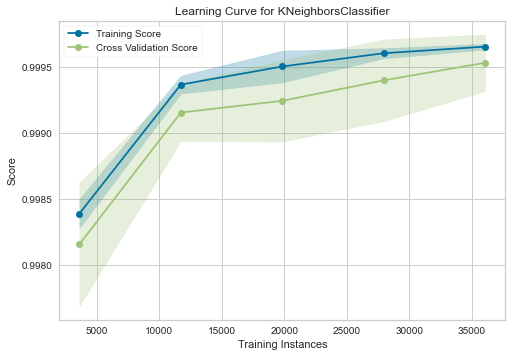


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



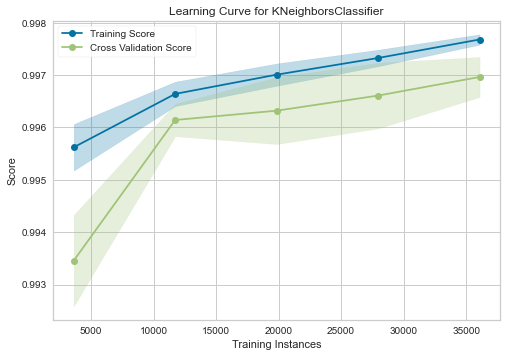

In [7]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


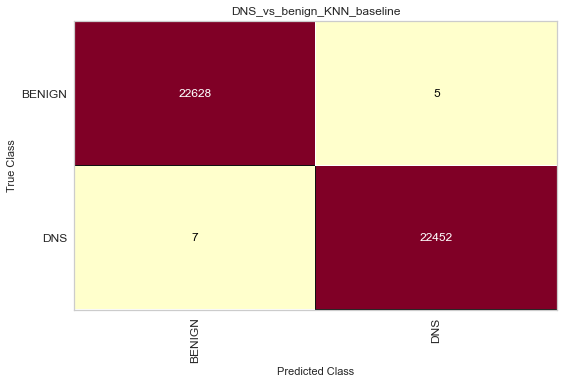

In [8]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


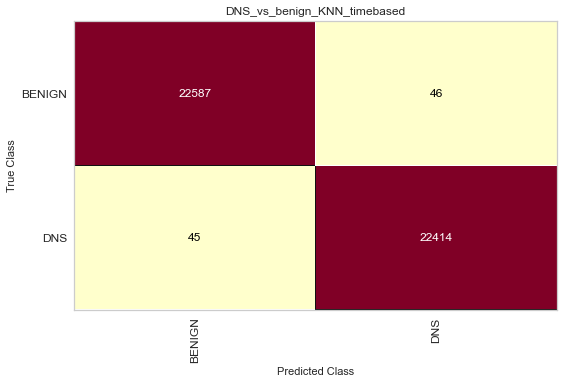

In [9]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


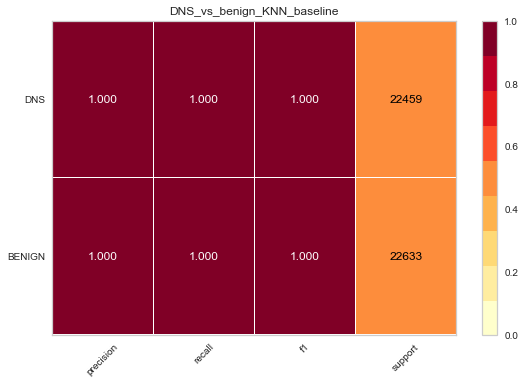

In [10]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


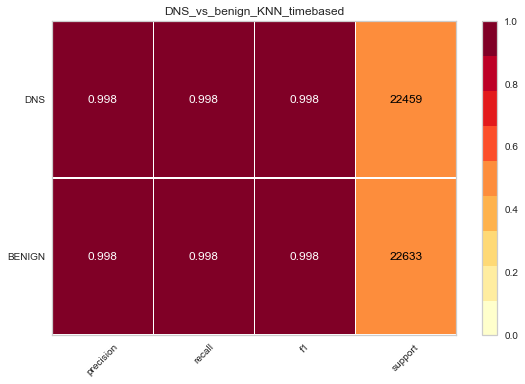

In [11]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


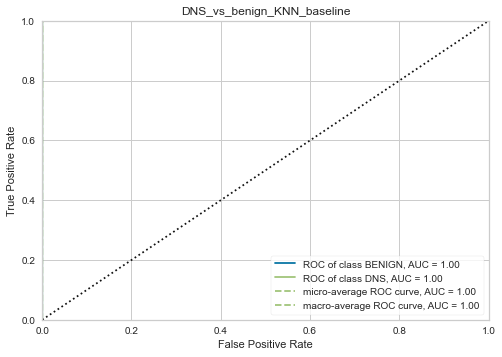

In [12]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


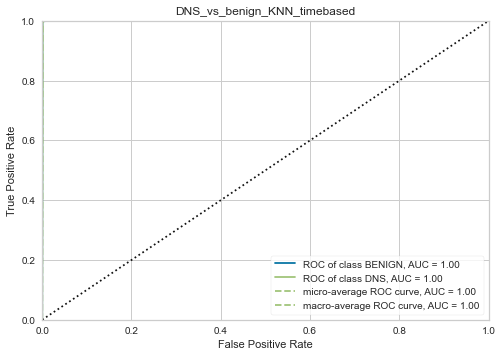

In [13]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


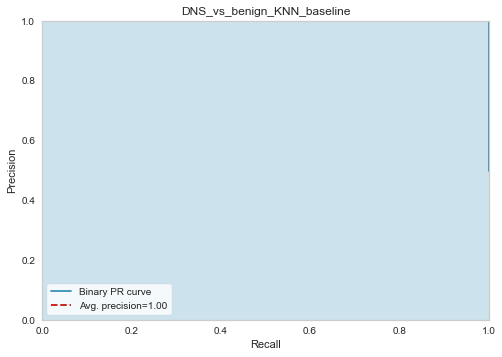

In [14]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


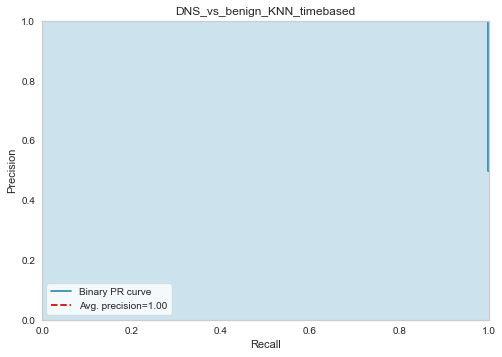

In [16]:
visualize_pr_curve(results[Timebased])

Running experiment #2:	LDAP
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



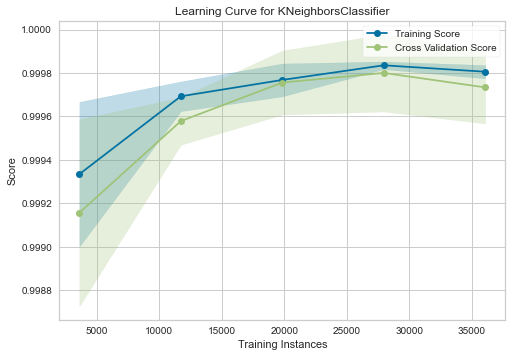


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



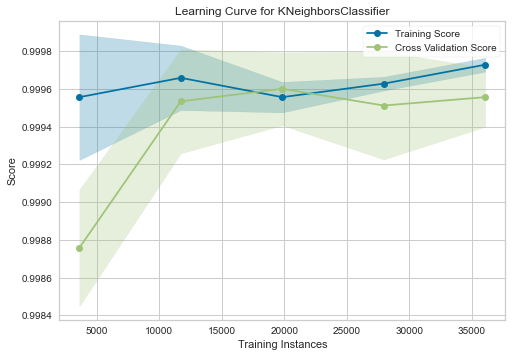

In [17]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


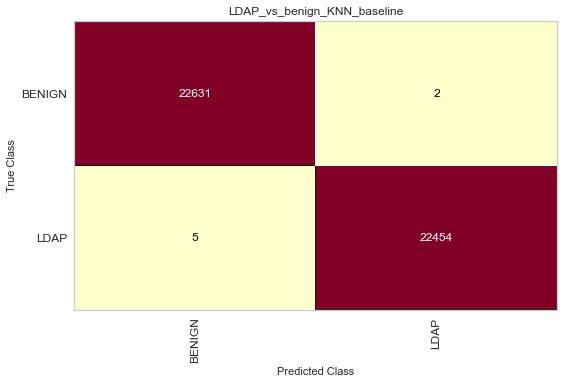

In [18]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


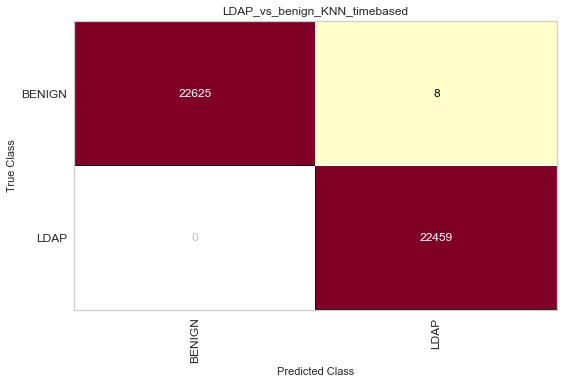

In [19]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


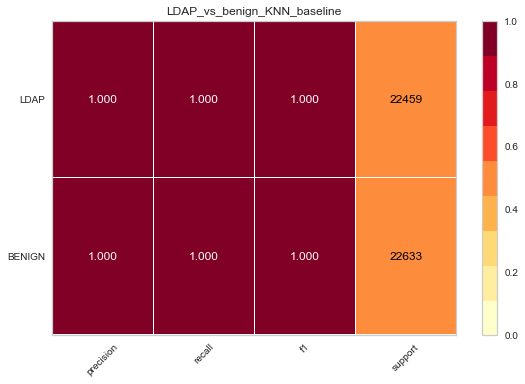

In [20]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


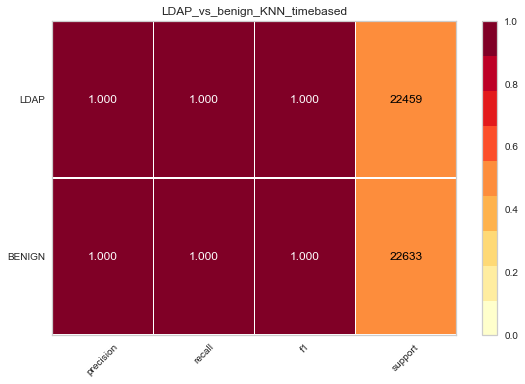

In [21]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


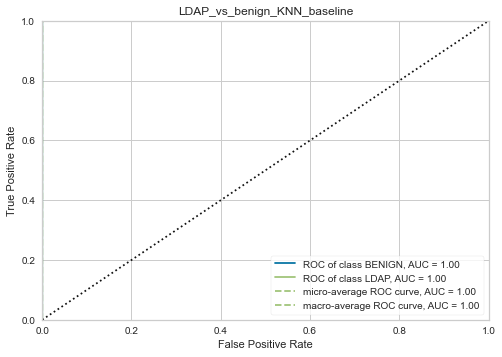

In [22]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


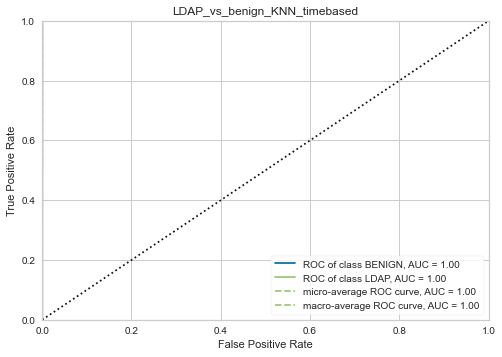

In [23]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


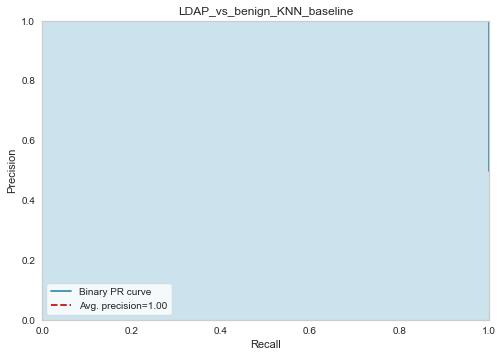

In [24]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


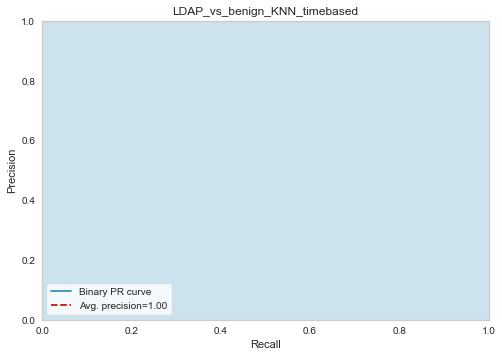

In [25]:
visualize_pr_curve(results[Timebased])

Running experiment #3:	MSSQL
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



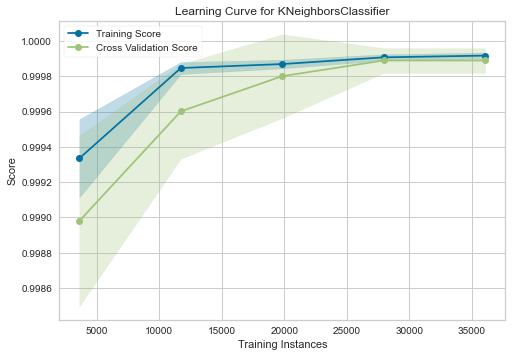


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



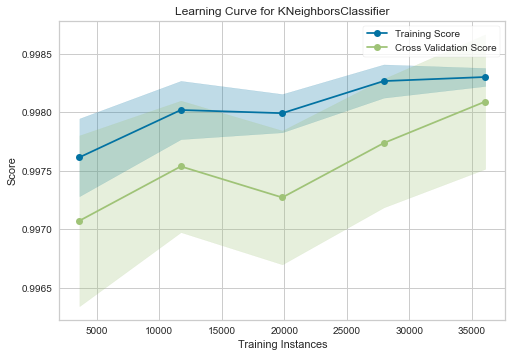

In [26]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


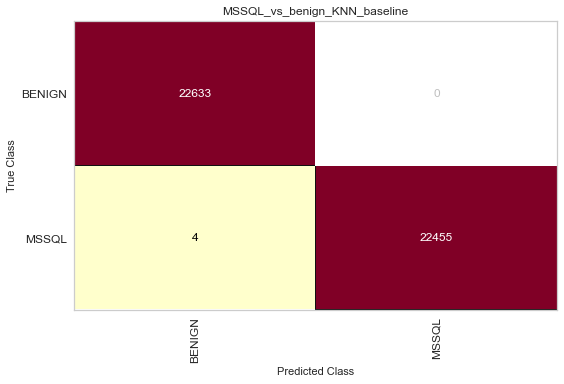

In [27]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


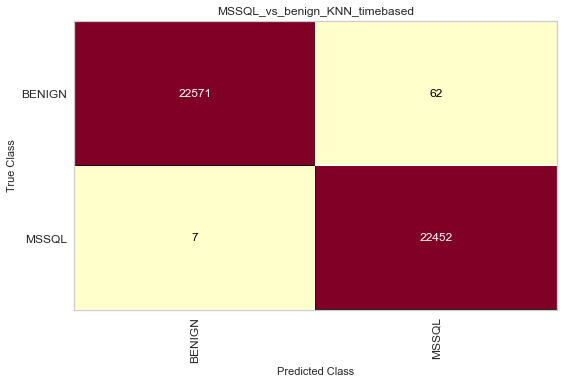

In [28]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


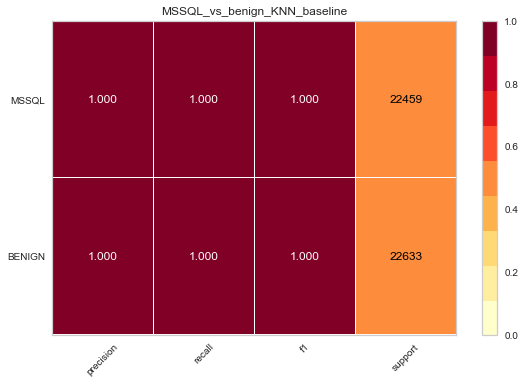

In [29]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


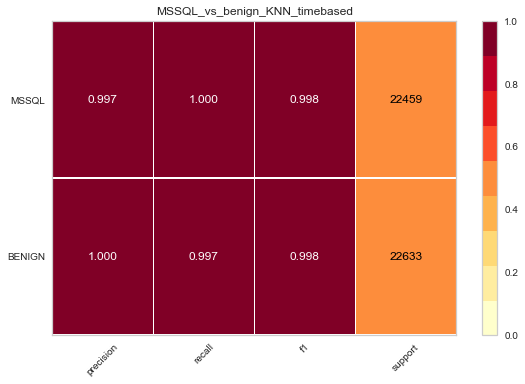

In [30]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


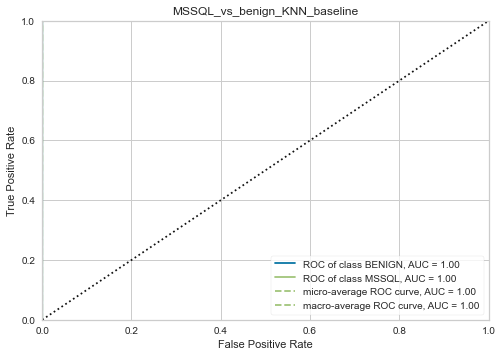

In [31]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


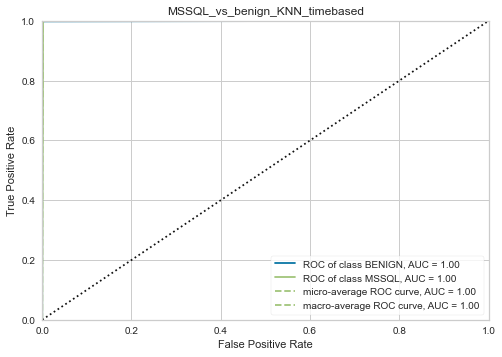

In [32]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


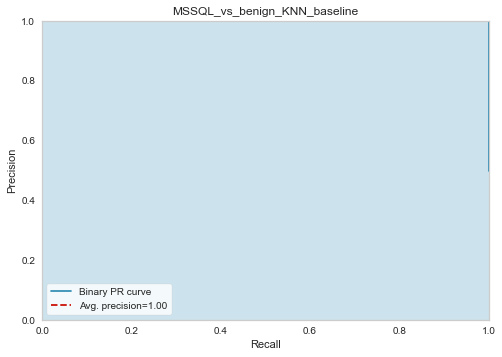

In [33]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


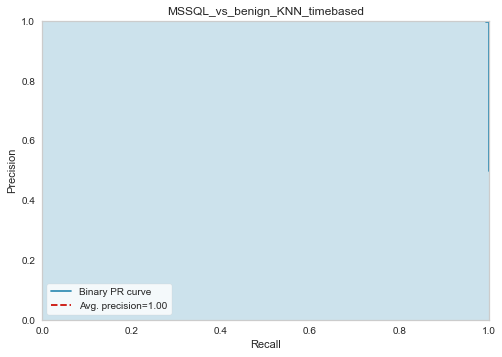

In [34]:
visualize_pr_curve(results[Timebased])

Running experiment #4:	NetBIOS
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



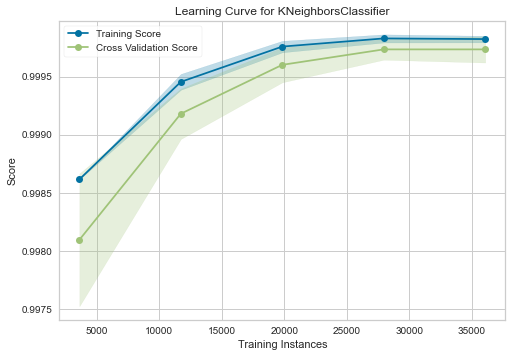


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



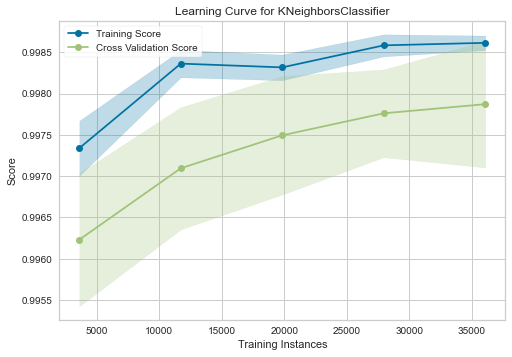

In [35]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


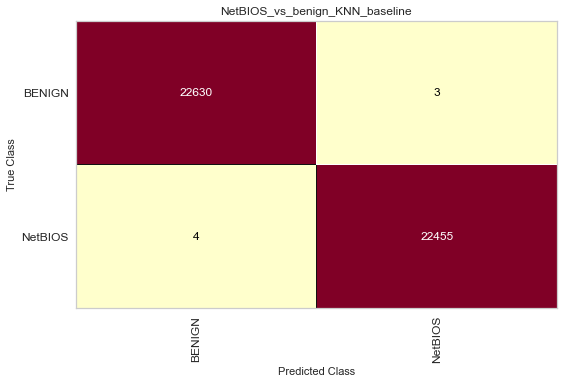

In [36]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


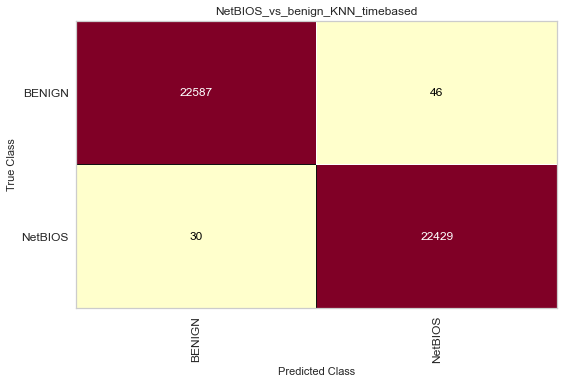

In [37]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


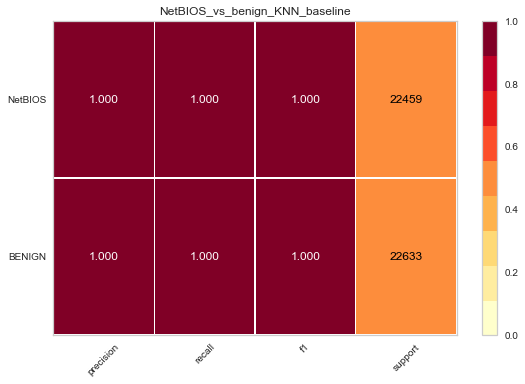

In [38]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


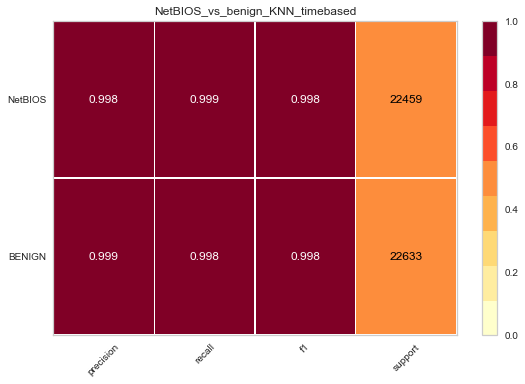

In [39]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


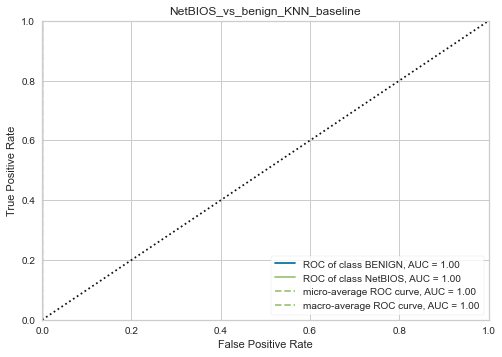

In [40]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


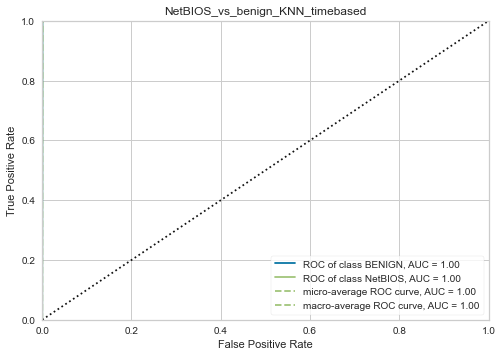

In [41]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


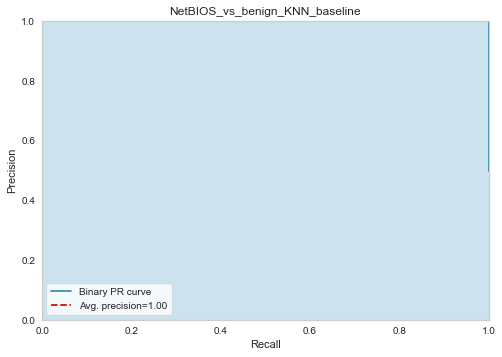

In [42]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


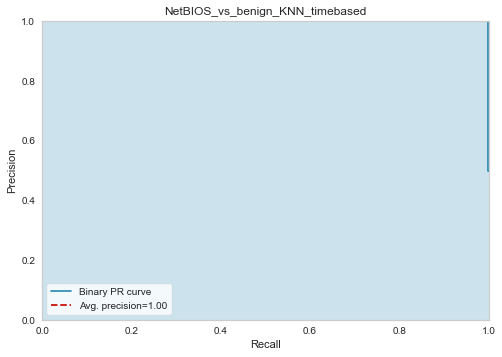

In [43]:
visualize_pr_curve(results[Timebased])

Running experiment #5:	NTP
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



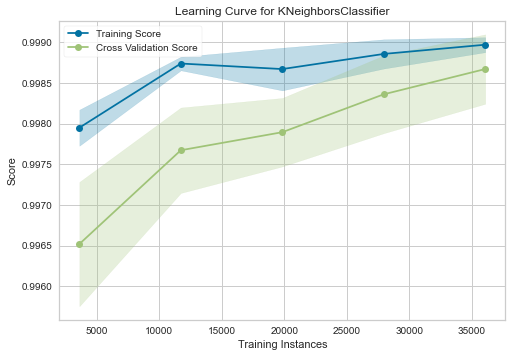


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



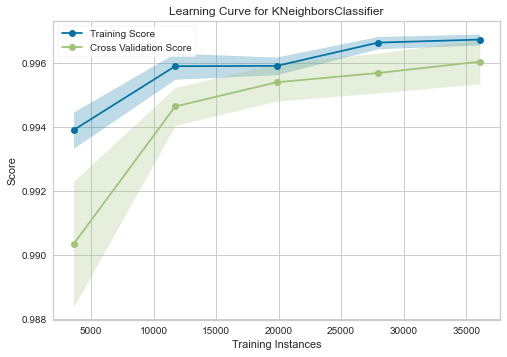

In [44]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


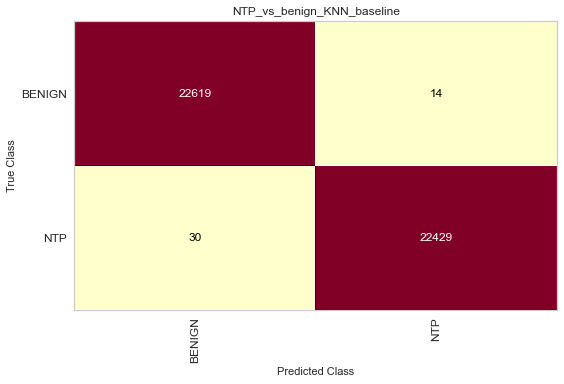

In [45]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


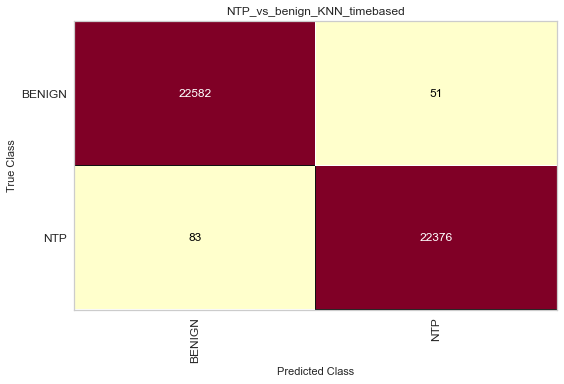

In [46]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


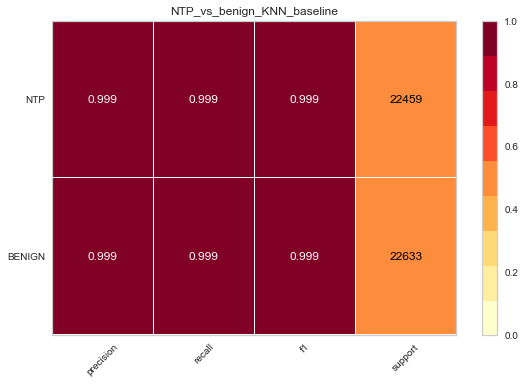

In [47]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


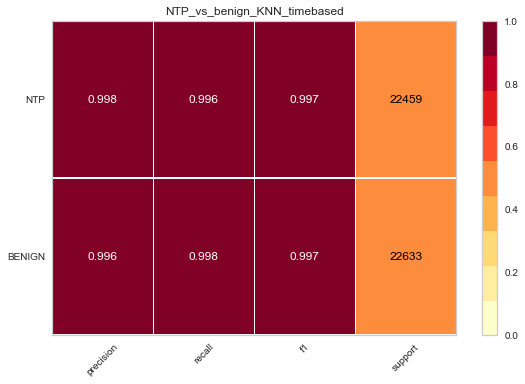

In [48]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


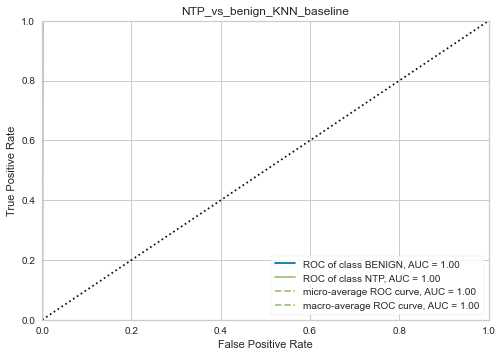

In [49]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


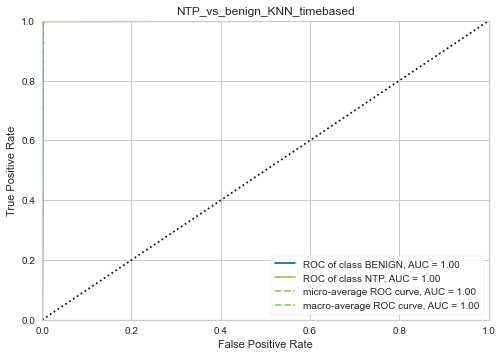

In [50]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


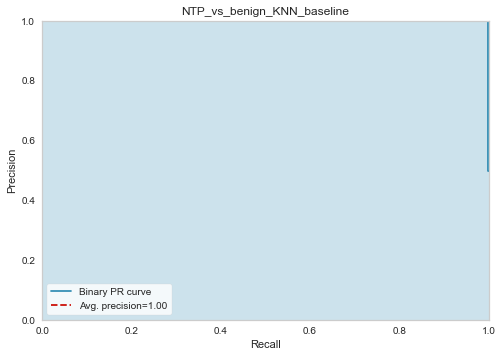

In [51]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


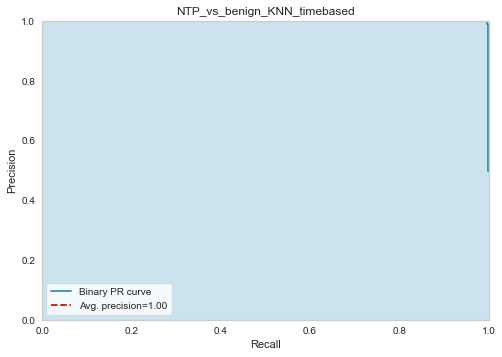

In [52]:
visualize_pr_curve(results[Timebased])

Running experiment #6:	Portmap
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



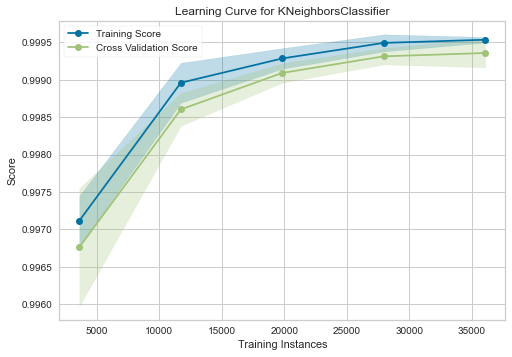


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



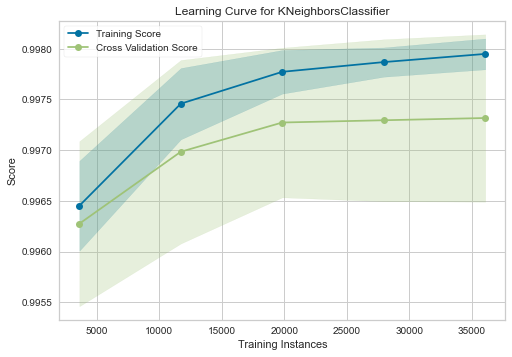

In [53]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


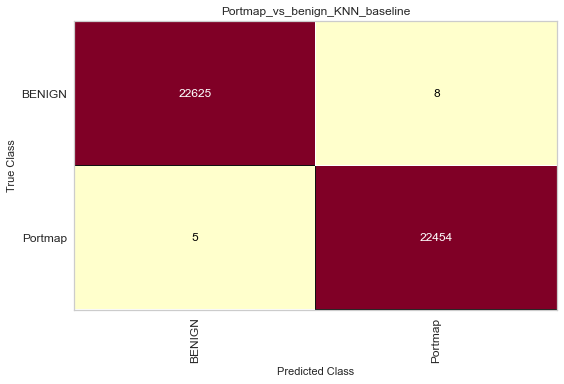

In [54]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


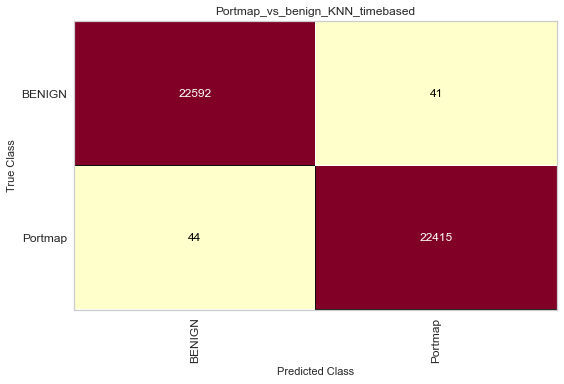

In [55]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


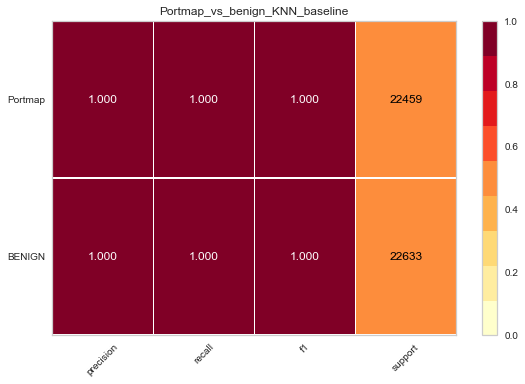

In [56]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


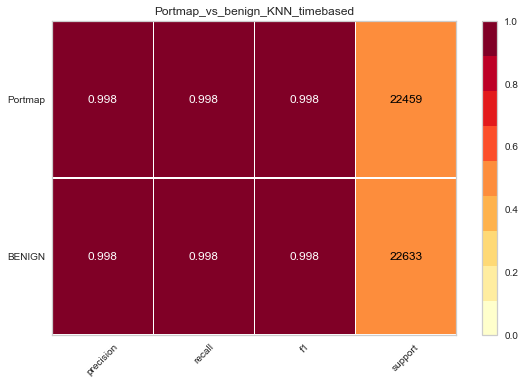

In [57]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


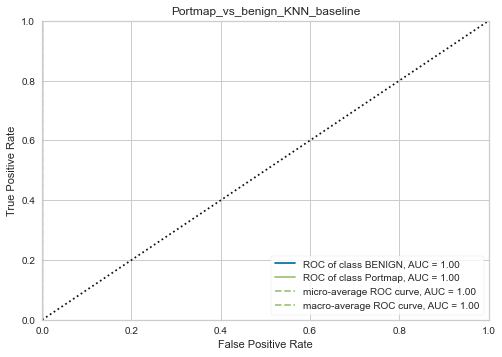

In [58]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


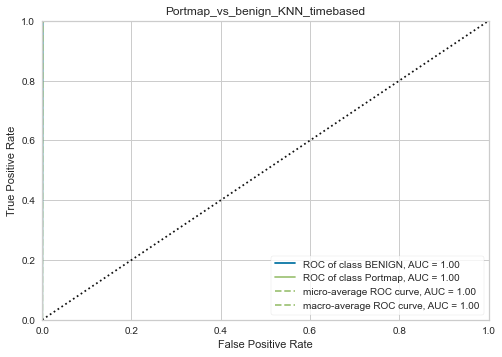

In [59]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


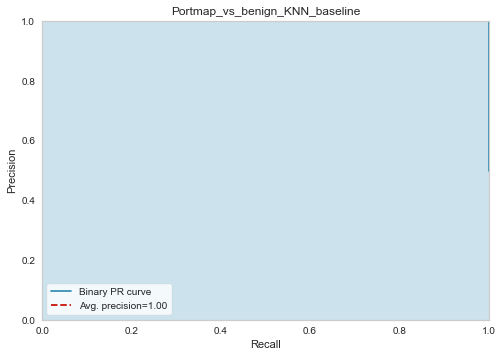

In [60]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


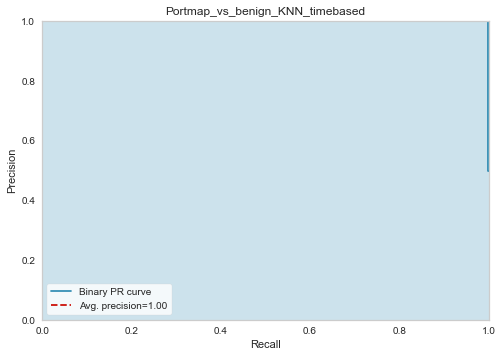

In [61]:
visualize_pr_curve(results[Timebased])

Running experiment #7:	SNMP
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



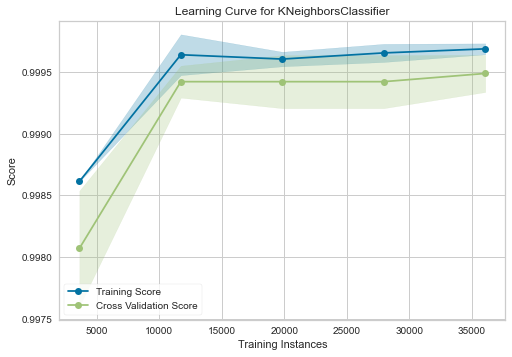


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



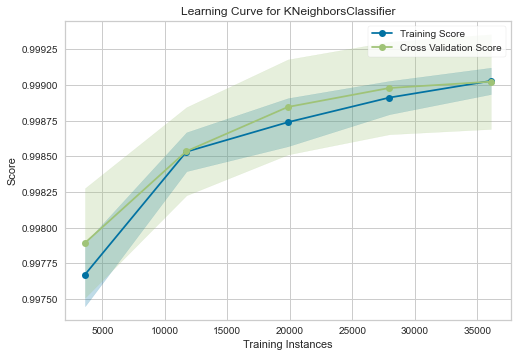

In [62]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


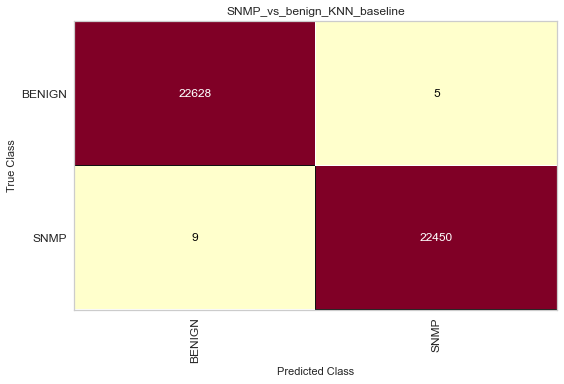

In [63]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


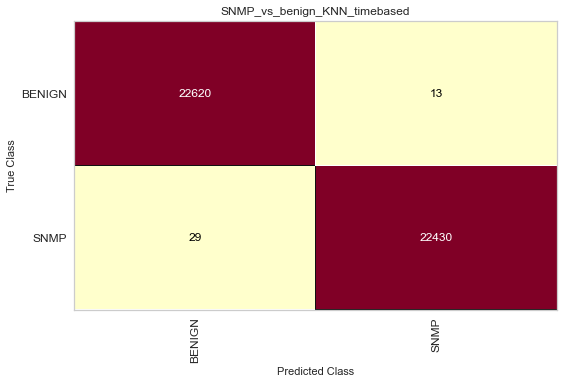

In [64]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


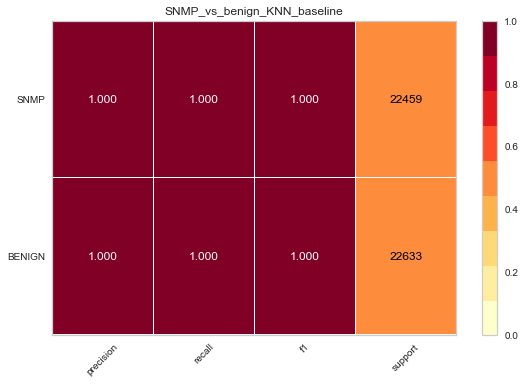

In [65]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


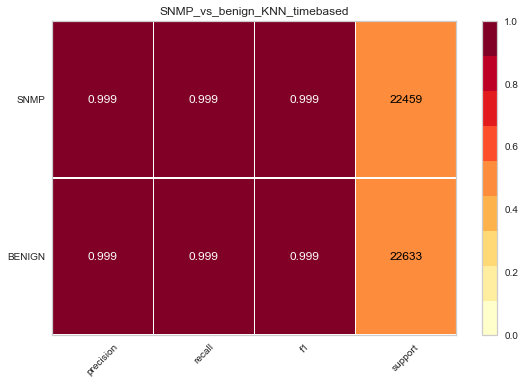

In [66]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


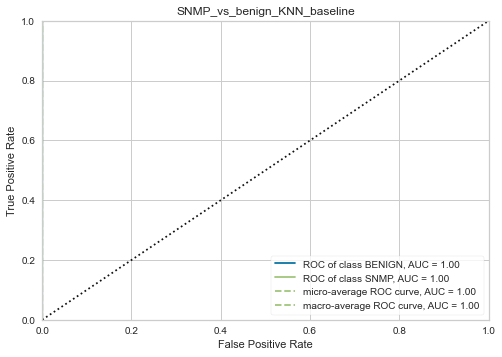

In [67]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


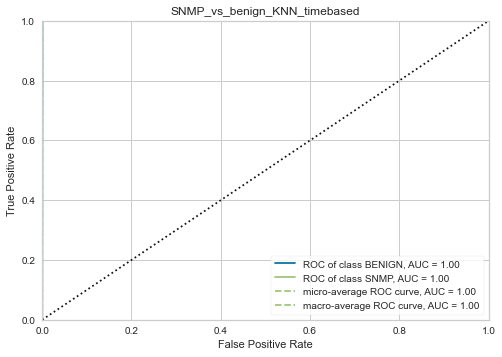

In [68]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


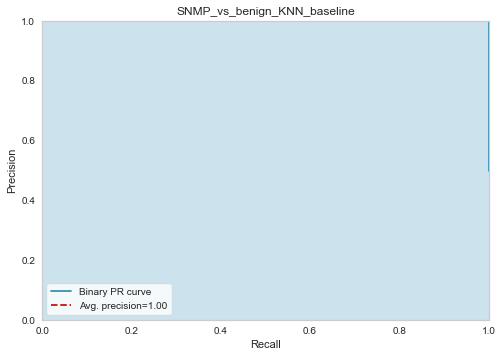

In [69]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


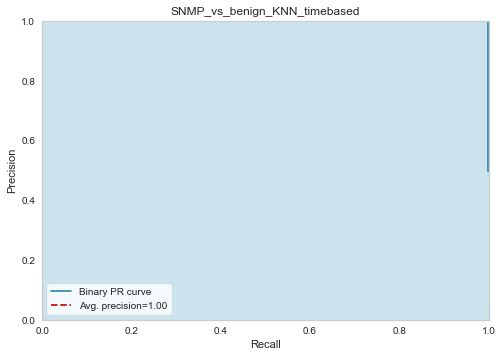

In [70]:
visualize_pr_curve(results[Timebased])

Running experiment #8:	SSDP
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



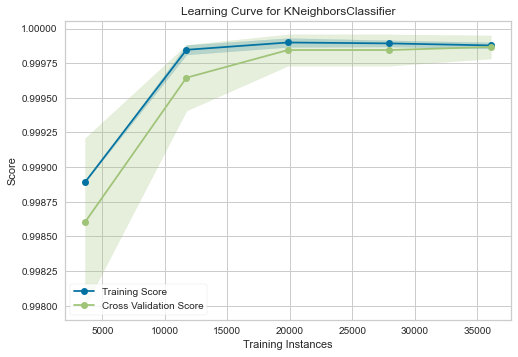


Time-based results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



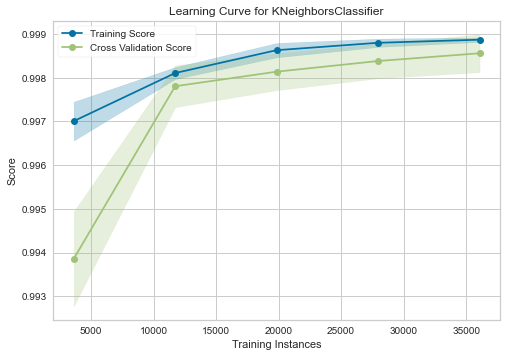

In [71]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


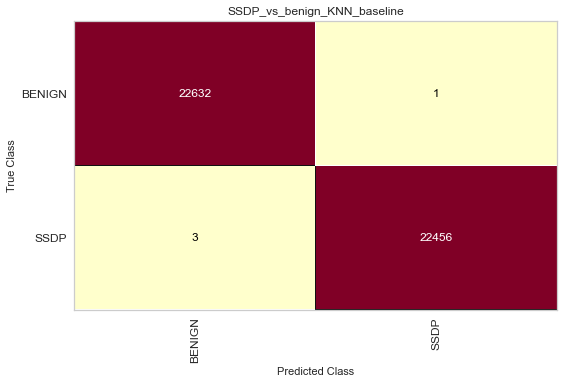

In [72]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


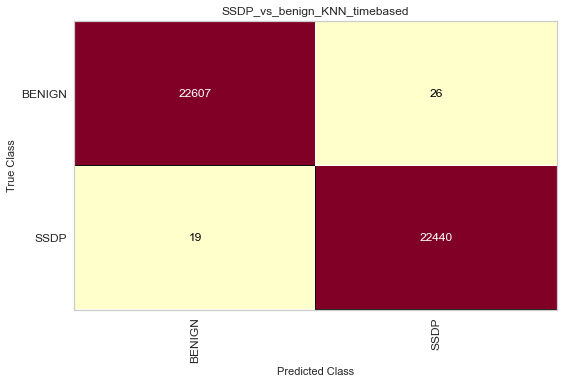

In [73]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


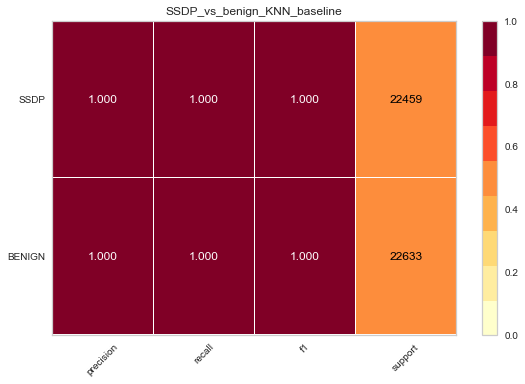

In [74]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


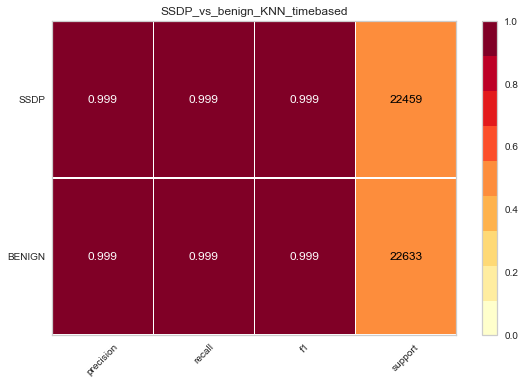

In [75]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


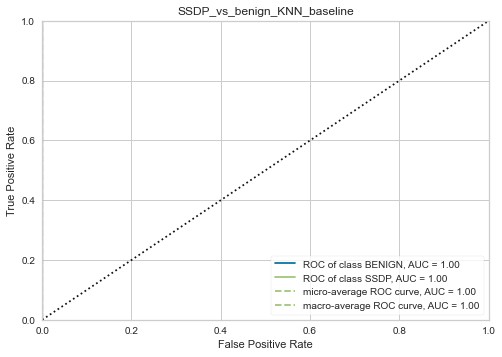

In [76]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


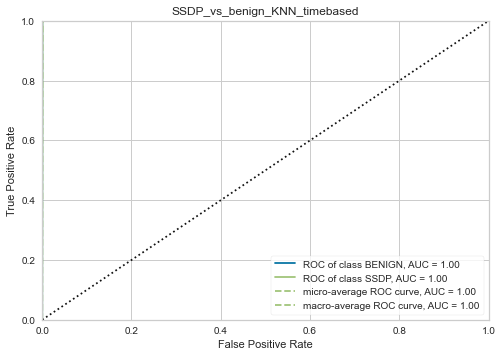

In [77]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


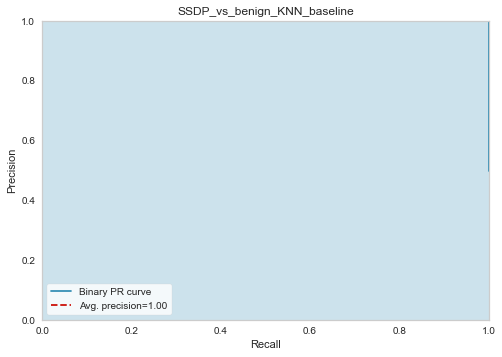

In [78]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


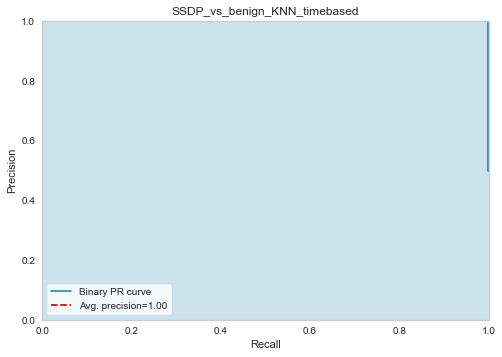

In [79]:
visualize_pr_curve(results[Timebased])

Running experiment #9:	Syn
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



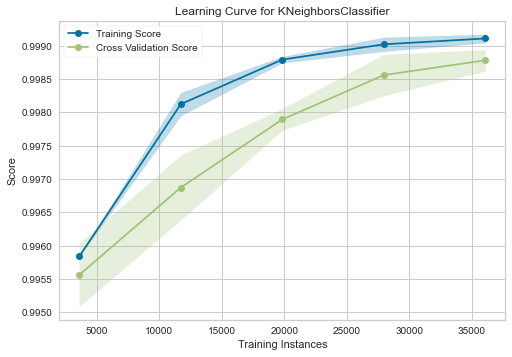


Time-based results
              precision    recall  f1-score   support

           0       0.98      0.96      0.97     22633
           1       0.96      0.98      0.97     22459

    accuracy                           0.97     45092
   macro avg       0.97      0.97      0.97     45092
weighted avg       0.97      0.97      0.97     45092



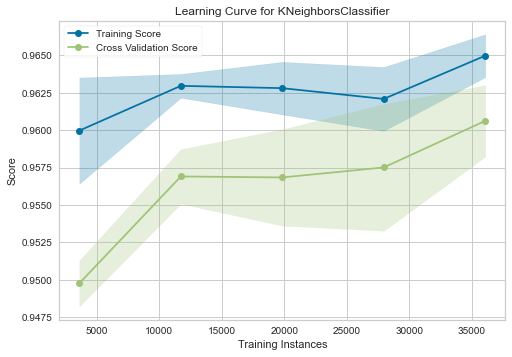

In [80]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


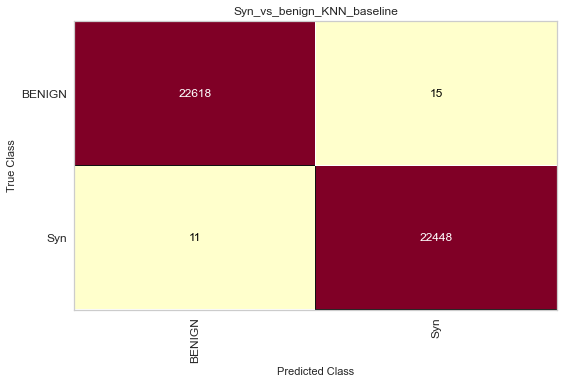

In [81]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


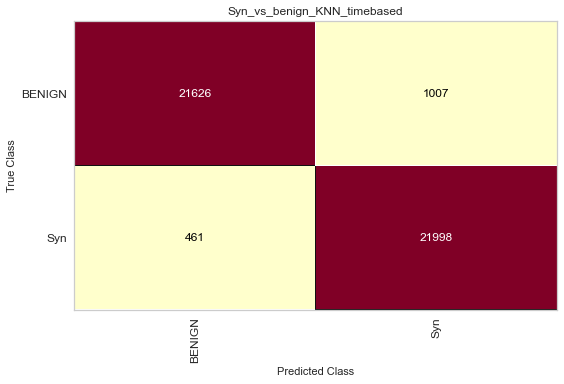

In [82]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


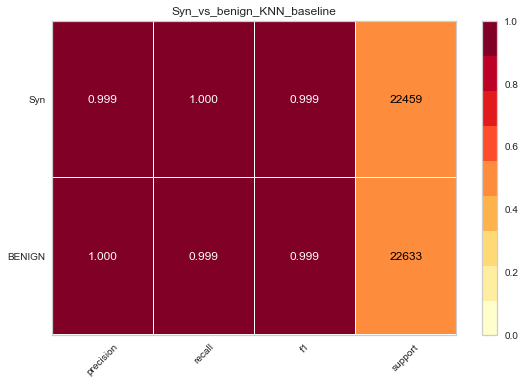

In [83]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


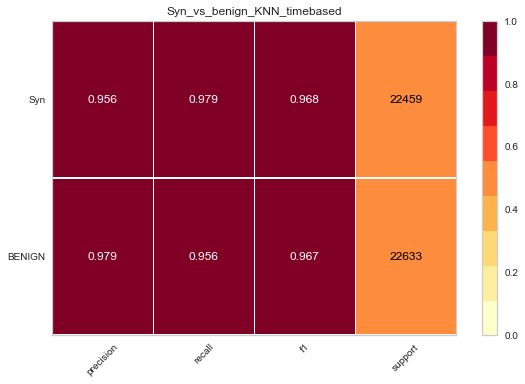

In [84]:
visualize_report(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


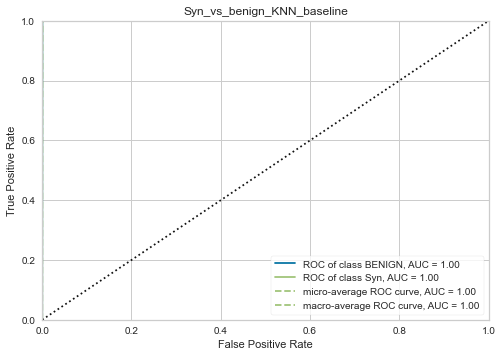

In [85]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


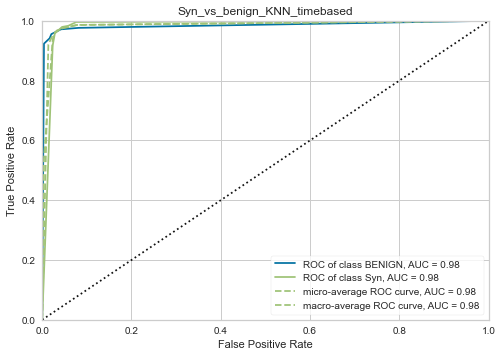

In [86]:
visualize_roc(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


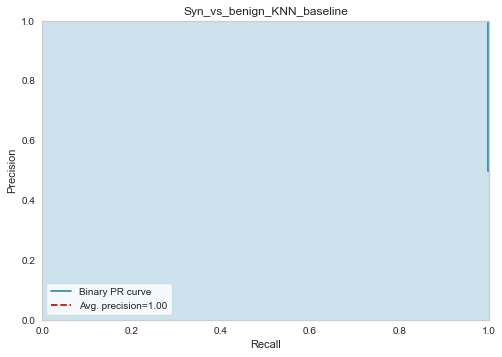

In [87]:
visualize_pr_curve(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


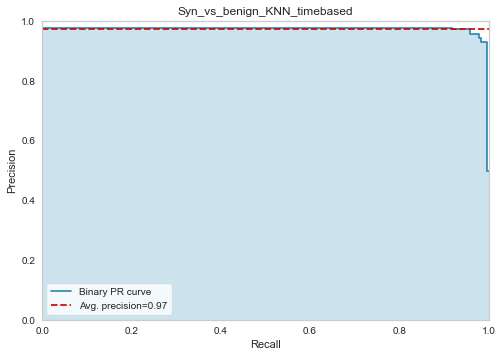

In [88]:
visualize_pr_curve(results[Timebased])

Running experiment #10:	TFTP
Baseline results
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     22633
           1       1.00      1.00      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



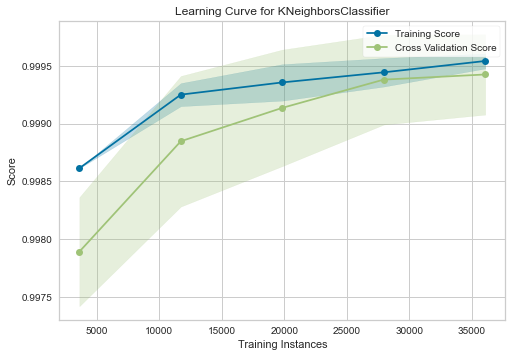


Time-based results
              precision    recall  f1-score   support

           0       0.99      1.00      1.00     22633
           1       1.00      0.99      1.00     22459

    accuracy                           1.00     45092
   macro avg       1.00      1.00      1.00     45092
weighted avg       1.00      1.00      1.00     45092



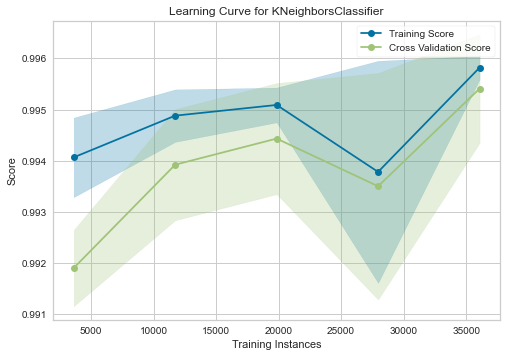

In [89]:
results = next(experiment)

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


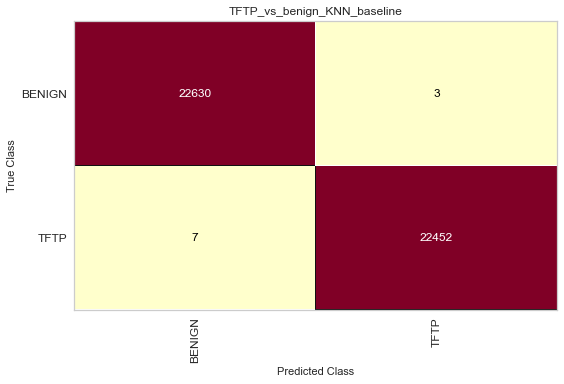

In [90]:
visualize_confusion_matrix(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


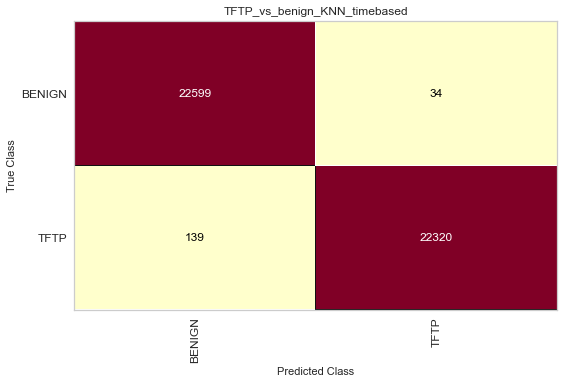

In [91]:
visualize_confusion_matrix(results[Timebased])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


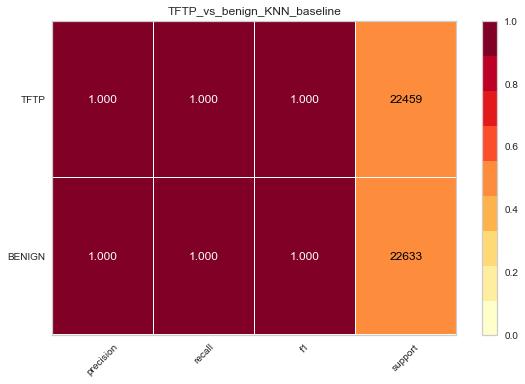

In [92]:
visualize_report(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


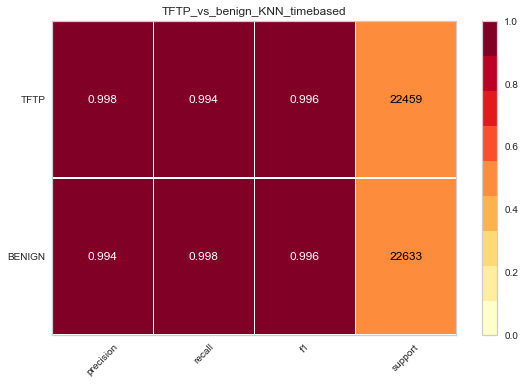

In [93]:
visualize_report(results[Timebased])

In [94]:
visualize_roc(results[Baseline])

C:\ProgramData\Anaconda3\lib\site-packages\yellowbrick\classifier\base.py:234: YellowbrickWarning: could not determine class_counts_ from previously fitted classifier
  YellowbrickWarning,


In [ ]:
visualize_roc(results[Timebased])

In [ ]:
visualize_pr_curve(results[Baseline])

In [ ]:
visualize_pr_curve(results[Timebased])

In [ ]:
results = next(experiment)

In [ ]:
visualize_confusion_matrix(results[Baseline])

In [ ]:
visualize_confusion_matrix(results[Timebased])

In [ ]:
visualize_report(results[Baseline])

In [ ]:
visualize_report(results[Timebased])

In [ ]:
visualize_roc(results[Baseline])

In [ ]:
visualize_roc(results[Timebased])

In [ ]:
visualize_pr_curve(results[Baseline])

In [ ]:
visualize_pr_curve(results[Timebased])

In [ ]:
results = next(experiment)

In [ ]:
visualize_confusion_matrix(results[Baseline])

In [ ]:
visualize_confusion_matrix(results[Timebased])

In [ ]:
visualize_report(results[Baseline])

In [ ]:
visualize_report(results[Timebased])

In [ ]:
visualize_roc(results[Baseline])

In [ ]:
visualize_roc(results[Timebased])

In [ ]:
visualize_pr_curve(results[Baseline])

In [ ]:
visualize_pr_curve(results[Timebased])